<a href="https://colab.research.google.com/github/anirudh-g/Msc-Data-science/blob/master/Chart_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<H1> SETUP </H1>

In [120]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
import matplotlib.pyplot as plt
import numpy as np

In [113]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [177]:
#For now - 7 classes: Area chart, Bar chart, Line Chart, pie chart, scatter plot. 100 images per class. 80/20 train/val split
#train_dir = '/content/drive/My Drive/Colab Notebooks/Train'
#validation_dir = '/content/drive/My Drive/Colab Notebooks/Validation'

train_dir = '/content/drive/My Drive/Colab Notebooks/Charts_5/Train'
validation_dir = '/content/drive/My Drive/Colab Notebooks/Charts_5/Validation'


<H1>BASELINE MODEL</H1>

In [178]:
#List of all basic tunable parameters of the model - to be updated
img_width, img_height = 150, 150
nb_train_samples = 80
nb_validation_samples = 20
epochs = 30
batch_size = 10

In [179]:
#checking whether the rgb channel is first or last to feed the input shape accordingly
if K.image_data_format() == 'channels_first': 
    input_shape = (3, img_width, img_height) 
else: 
    input_shape = (img_width, img_height, 3) 

# 3 CNN blocks containing a max pooling layer in each of them. On top of that is a fully connected layer with relu activation function
model = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=input_shape),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(5, activation='softmax') #Nodes in the final dense layer should be equal to number of classes + softmax activation
])


model.compile(optimizer='adam',
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=['accuracy'])

model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_143 (Conv2D)          (None, 150, 150, 16)      448       
_________________________________________________________________
max_pooling2d_53 (MaxPooling (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_144 (Conv2D)          (None, 75, 75, 32)        4640      
_________________________________________________________________
max_pooling2d_54 (MaxPooling (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_145 (Conv2D)          (None, 37, 37, 64)        18496     
_________________________________________________________________
max_pooling2d_55 (MaxPooling (None, 18, 18, 64)        0         
_________________________________________________________________
flatten_16 (Flatten)         (None, 20736)           

In [180]:
#Performing augmentation on image scaling, zoom and fliiping the images horizontally so that the network has more training samples
train_datagen = ImageDataGenerator( 
	rescale=1. / 255, 
	shear_range=0.2, 
	zoom_range=0.2, 
	horizontal_flip=True) 

#Not having any augmentation apart from scaling as the validation data should resemble the real-world data as close as possible
val_datagen = ImageDataGenerator(rescale=1. / 255) 

train_generator = train_datagen.flow_from_directory( 
	train_dir, 
	target_size=(img_width, img_height), 
	batch_size=batch_size, 
	class_mode='categorical') 

validation_generator = val_datagen.flow_from_directory( 
	validation_dir, 
	target_size=(img_width, img_height), 
	batch_size=batch_size, 
	class_mode='categorical') 

history = model.fit( 
	train_generator, 
	steps_per_epoch=nb_train_samples // batch_size, 
	epochs=epochs, 
	validation_data=validation_generator, 
	validation_steps=nb_validation_samples // batch_size) 


Found 400 images belonging to 5 classes.
Found 100 images belonging to 5 classes.
Epoch 1/30
8/8 [==============================] - 51s 6s/step - loss: 1.8555 - accuracy: 0.2375 - val_loss: 1.6427 - val_accuracy: 0.2500
Epoch 2/30
8/8 [==============================] - 36s 4s/step - loss: 1.5334 - accuracy: 0.3125 - val_loss: 1.3269 - val_accuracy: 0.3500
Epoch 3/30
8/8 [==============================] - 30s 4s/step - loss: 1.4091 - accuracy: 0.3750 - val_loss: 1.6121 - val_accuracy: 0.4000
Epoch 4/30
8/8 [==============================] - 18s 2s/step - loss: 1.4001 - accuracy: 0.4500 - val_loss: 1.2695 - val_accuracy: 0.4500
Epoch 5/30
8/8 [==============================] - 15s 2s/step - loss: 1.2702 - accuracy: 0.4500 - val_loss: 1.6218 - val_accuracy: 0.6000
Epoch 6/30
8/8 [==============================] - 15s 2s/step - loss: 0.8893 - accuracy: 0.6250 - val_loss: 1.2268 - val_accuracy: 0.3500
Epoch 7/30
8/8 [==============================] - 9s 1s/step - loss: 1.1317 - accuracy: 0.

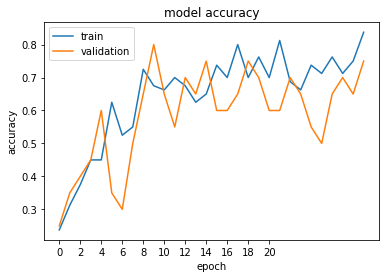

In [181]:

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.xticks(np.arange(0,21, 2))
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

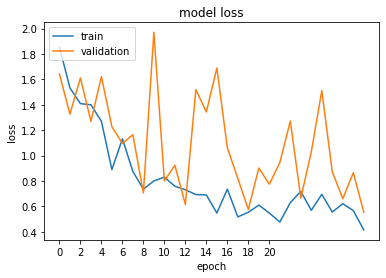

In [182]:
# summarize history for loss https://www.kaggle.com/prateek0x/multiclass-image-classification-using-keras
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.xticks(np.arange(0,21, 2))
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [183]:
print(validation_generator.class_indices)

{'AreaChart': 0, 'BarChart': 1, 'LineChart': 2, 'PieChart': 3, 'ScatterPlot': 4}


In [184]:
final_loss, final_accuracy = model.evaluate(validation_generator, steps = nb_validation_samples // batch_size)
print("Final loss: {:.2f}".format(final_loss))
print("Final accuracy: {:.2f}%".format(final_accuracy * 100))

2/2 [==============================] - 0s 63ms/step - loss: 0.3653 - accuracy: 0.9000
Final loss: 0.37
Final accuracy: 90.00%


TRANSFER LEARNING

In [197]:
from tensorflow.keras.applications.VGG16 import VGG16
base_model = VGG16(weights=None, include_top=False, input_shape=input_shape, classes=5)
base_model.summary()

ModuleNotFoundError: ignored

In [192]:
base_model.trainable=False

In [193]:
inputs = keras.Input(shape=input_shape)
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning, as you will
# learn in a few paragraphs.
x = base_model(inputs, training=False)
# Convert features of shape `base_model.output_shape[1:]` to vectors
x = keras.layers.GlobalAveragePooling2D()(x)
# A Dense classifier with a single unit (binary classification)
outputs = keras.layers.Dense(5)(x)
tl_model = keras.Model(inputs, outputs)

In [194]:
tl_model.compile(optimizer='adam',
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=['accuracy'])

tl_history = tl_model.fit( 
	train_generator, 
	steps_per_epoch=nb_train_samples // batch_size, 
	epochs=epochs, 
	validation_data=validation_generator, 
	validation_steps=nb_validation_samples // batch_size) 


Epoch 1/30
8/8 [==============================] - 6s 703ms/step - loss: 7.6117 - accuracy: 0.3125 - val_loss: 5.8505 - val_accuracy: 0.1500
Epoch 2/30
8/8 [==============================] - 5s 589ms/step - loss: 8.1397 - accuracy: 0.3750 - val_loss: 12.0886 - val_accuracy: 0.3000
Epoch 3/30
8/8 [==============================] - 5s 574ms/step - loss: 10.9918 - accuracy: 0.2625 - val_loss: 11.5100 - val_accuracy: 0.2000
Epoch 4/30
8/8 [==============================] - 5s 591ms/step - loss: 9.5307 - accuracy: 0.2125 - val_loss: 9.7542 - val_accuracy: 0.1500
Epoch 5/30
8/8 [==============================] - 5s 591ms/step - loss: 10.3024 - accuracy: 0.2500 - val_loss: 11.2827 - val_accuracy: 0.2000
Epoch 6/30
8/8 [==============================] - 5s 596ms/step - loss: 9.8727 - accuracy: 0.3625 - val_loss: 8.8703 - val_accuracy: 0.4000
Epoch 7/30
8/8 [==============================] - 5s 597ms/step - loss: 9.8729 - accuracy: 0.3500 - val_loss: 12.1024 - val_accuracy: 0.1500
Epoch 8/30
8/8